### Project Source : https://www.youtube.com/watch?v=9hLcBgnY7cs
### Git -> https://github.com/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb

# Siamese Network for Face Recognition

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

c:\Users\nati\Desktop\Implementations\ImplementationsVenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Creating some helper functions
def imshow(img, text=None):
    # Numpy Image
    npimg = img.numpy()
    # Removing The Axis
    plt.axis("off")
    # If Theres a text - Set the text at x = 75 y = 8
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    # Show Image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
# Loss plot through Iterations
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
     

# Dataset Class

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        #Images Folder path
        self.imageFolderDataset = imageFolderDataset   
        # Transformations 
        self.transform = transform
        
    def __getitem__(self,index):
        # Randomly Choosing Images
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break
        # Reading the images
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        # Gray Scale Conversion
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        # If transformation
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        # Returning img0,img1 and the label (are they of the same person or not - Same person == 0 , Different person == 1)
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)    

### Downloading the Dataset

In [6]:
import os
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

'wget' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Load the training Dataset

In [7]:
folder_dataset = datasets.ImageFolder(root=r"C:\Users\nati\Desktop\Implementations\SiameseNetwork_FaceRecognition\at&t\data\faces\training")


In [8]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the Dataset Class
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

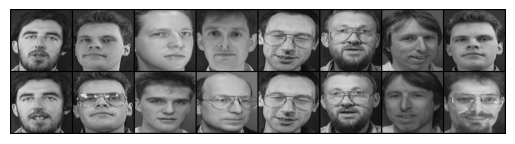

[0. 0. 1. 1. 0. 0. 0. 1.]


In [14]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))
     

## Creating the Siamese Network

In [15]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
     


![Alt text](%D7%94%D7%95%D7%A8%D7%93%D7%94.png)

In [16]:
# Define the Contrastive Loss Function as pytorch class
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive
     


In [17]:

# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=64)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:

net = SiameseNetwork().to(device=device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

# Training the Network

Epoch number 0
 Current loss 2.185344696044922

Epoch number 1
 Current loss 1.2615447044372559

Epoch number 2
 Current loss 0.6771939992904663

Epoch number 3
 Current loss 0.8732002377510071

Epoch number 4
 Current loss 0.7933814525604248

Epoch number 5
 Current loss 0.6822044849395752

Epoch number 6
 Current loss 0.66129070520401

Epoch number 7
 Current loss 0.5294532775878906

Epoch number 8
 Current loss 0.7663997411727905

Epoch number 9
 Current loss 0.5753977298736572

Epoch number 10
 Current loss 0.5068224668502808

Epoch number 11
 Current loss 0.5900773406028748

Epoch number 12
 Current loss 0.3860588073730469

Epoch number 13
 Current loss 0.4701080918312073

Epoch number 14
 Current loss 0.3712001442909241

Epoch number 15
 Current loss 0.41246652603149414

Epoch number 16
 Current loss 0.3850403130054474

Epoch number 17
 Current loss 0.3280535638332367

Epoch number 18
 Current loss 0.46414124965667725

Epoch number 19
 Current loss 0.34555289149284363

Epoch numb

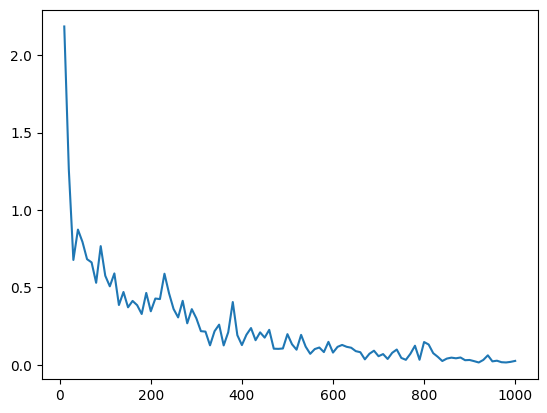

In [20]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

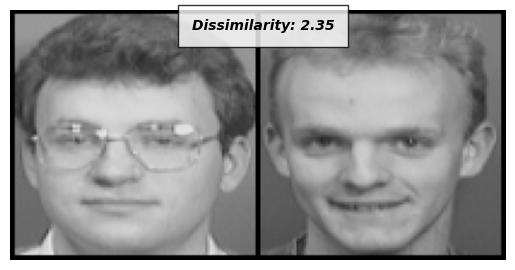

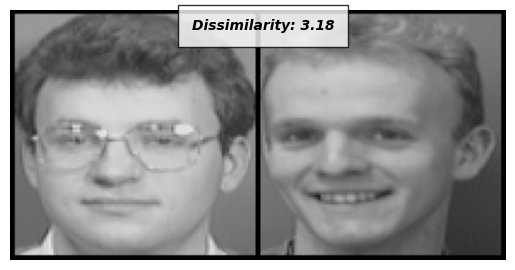

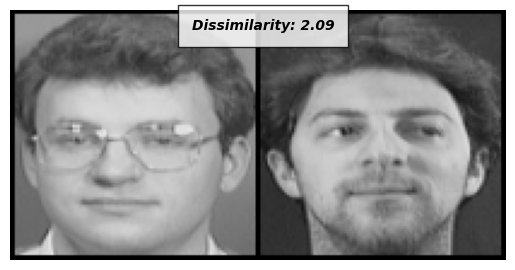

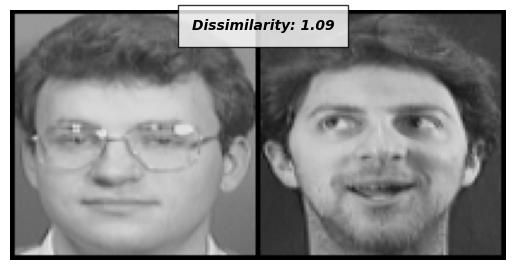

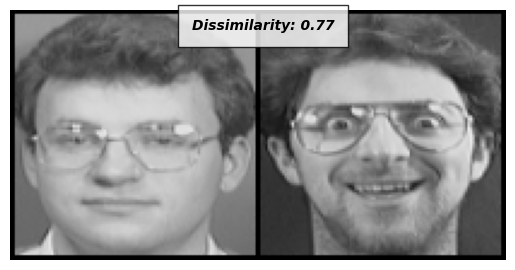

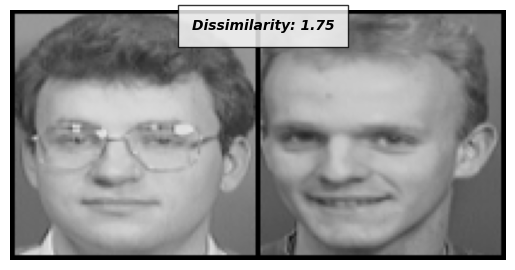

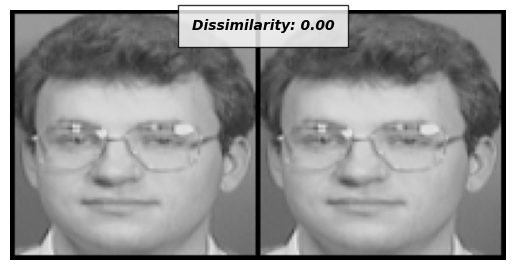

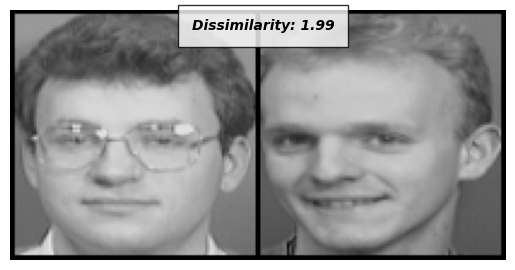

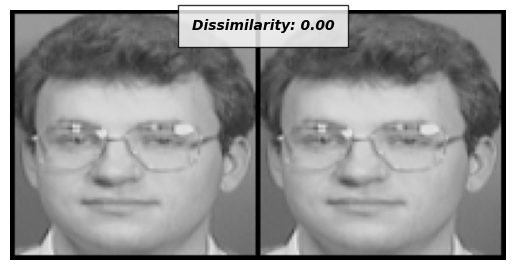

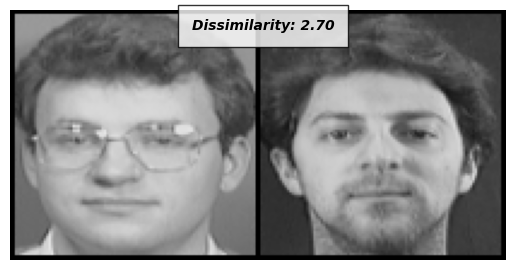

In [22]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root=r"C:\Users\nati\Desktop\Implementations\SiameseNetwork_FaceRecognition\at&t\data\faces\testing")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset,batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')